In [ ]:
!pip install tensorflow==2.15
!pip install scikit-learn

ERROR: Could not find a version that satisfies the requirement tensorflow==2.15 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.15


Loaded dataset: 549 rows, 32 columns
Train shape: (466, 32), Validation shape: (83, 32)

Class balance (training):
1    0.77897
0    0.22103
Name: proportion, dtype: float64

Class balance (validation):
1    0.783133
0    0.216867
Name: proportion, dtype: float64

✅ Final input dimension: 12

Class weights: {0: np.float64(2.262135922330097), 1: np.float64(0.6418732782369146)}

🚀 Starting manual randomized search for 50 combinations...


🧪 Trial 1/50: {'n_layers': 1, 'n_units': 5, 'activation': 'tanh', 'dropout_rate': 0.05, 'optimizer': 'adam', 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50}
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.3424 - loss: 0.8362 - val_accuracy: 0.5904 - val_loss: 0.6732
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5390 - loss: 0.7487 - val_accuracy: 0.6627 - val_loss: 0.6440
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5036 - loss: 0.7263 - val_accuracy: 0.6506 - val_loss: 0.6601
Epoch 4/50
8/8 ━━━━━

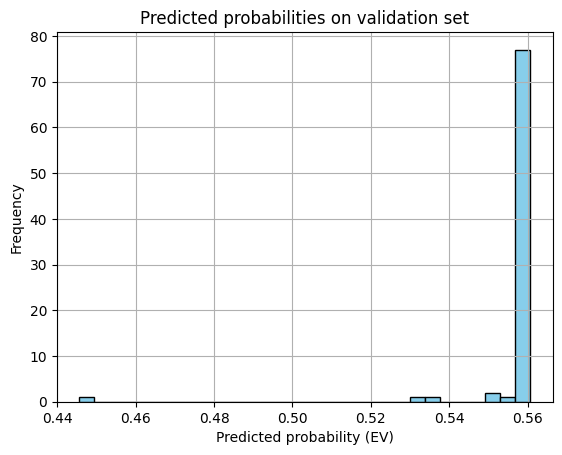


Predicted Probability Summary:
count    83.000000
mean      0.558396
std       0.013309
min       0.445652
25%       0.560729
50%       0.560729
75%       0.560729
max       0.560729
dtype: float64

🔍 First 15 utility-like values:
 0: prob=0.5607, logit=0.2441, actual=1
 1: prob=0.5607, logit=0.2441, actual=1
 2: prob=0.5607, logit=0.2441, actual=1
 3: prob=0.5607, logit=0.2441, actual=1
 4: prob=0.5607, logit=0.2441, actual=1
 5: prob=0.5607, logit=0.2441, actual=1
 6: prob=0.5607, logit=0.2441, actual=1
 7: prob=0.5607, logit=0.2441, actual=1
 8: prob=0.5521, logit=0.2093, actual=0
 9: prob=0.5607, logit=0.2441, actual=1
10: prob=0.5607, logit=0.2441, actual=1
11: prob=0.5607, logit=0.2441, actual=1
12: prob=0.4457, logit=-0.2183, actual=0
13: prob=0.5607, logit=0.2441, actual=1
14: prob=0.5607, logit=0.2441, actual=1

✅ Model saved as 'best_nn_ev_model.keras'


In [ ]:
# ============================================================
# 🚗 EV Adoption Model - Neural Network (85/15 Stratified Split, Seed=42)
# ============================================================

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers, callbacks

# --- Reproducibility ---
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
np.set_printoptions(precision=4, suppress=True)

# --- Load full dataset ---
data_path = r'/content/1.7L-1.9L_FINAL_binary_generated_exact - 1.7L-1.9L_FINAL_binary_generated_exact.csv (1).csv'
df = pd.read_csv(data_path)
print(f"Loaded dataset: {len(df)} rows, {len(df.columns)} columns")

# --- Define variables ---
continuous_features = ['ev_price_n', 'ev_fueln1', 'ev_rangen1', 'ev_loan', 'ev_reg1','age','income']
categorical_features = ['EV_Initial', 'EV_Ban', 'ev_res1', 'ev_res2','gender']
target_col = 'ev'

# --- Stratified 85/15 split (same as Biogeme setup) ---
train_df, valid_df = train_test_split(
    df,
    test_size=0.15,
    random_state=42,     # fixed seed for reproducibility
    stratify=df['ev']    # maintain same class proportion
)
print(f"Train shape: {train_df.shape}, Validation shape: {valid_df.shape}")

# --- Map target: 1 → conventional (0), 2 → EV (1) ---
def map_target(s):
    return np.where(s == 2, 1, 0)

y_train = map_target(train_df[target_col].values)
y_valid = map_target(valid_df[target_col].values)

# --- Class balance check ---
print("\nClass balance (training):")
print(pd.Series(y_train).value_counts(normalize=True))
print("\nClass balance (validation):")
print(pd.Series(y_valid).value_counts(normalize=True))

# --- Scale continuous vars (fit on train, apply to valid) ---
scaler = StandardScaler()
X_train_cont = scaler.fit_transform(train_df[continuous_features])
X_valid_cont = scaler.transform(valid_df[continuous_features])

# --- Keep categorical features as-is ---
X_train_cat = train_df[categorical_features].astype(float).values
X_valid_cat = valid_df[categorical_features].astype(float).values

# --- Combine features ---
X_train = np.concatenate([X_train_cont, X_train_cat], axis=1)
X_valid = np.concatenate([X_valid_cont, X_valid_cat], axis=1)

input_dim = X_train.shape[1]
print(f"\n✅ Final input dimension: {input_dim}")

# --- Compute class weights ---
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("\nClass weights:", class_weights)

# --- Build Keras model factory ---
def build_model(n_layers=2, n_units=64, activation='relu', dropout_rate=0.2,
                optimizer='adam', learning_rate=1e-3, input_dim=None):
    if input_dim is None:
        raise ValueError("input_dim must be specified")

    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    for _ in range(int(n_layers)):
        model.add(layers.Dense(int(n_units), activation=activation))
        if dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation='sigmoid'))

    if optimizer == 'adam':
        opt = optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    else:
        opt = optimizer

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# --- Define hyperparameter search space ---
param_dist = {
    'n_layers': [1, 2, 3, 4],
    'n_units': [5, 6, 7, 8, 16, 32, 64],
    'activation': ['relu', 'tanh'],
    'dropout_rate': [0.0, 0.05, 0.1, 0.2],
    'optimizer': ['adam', 'sgd'],
    'learning_rate': [0.1, 1e-2, 1e-3, 1e-4],
    'batch_size': [32, 40, 64],
    'epochs': [50, 100]
}

# --- Helper to sample random hyperparameters ---
def sample_params(param_dict):
    return {k: random.choice(v) for k, v in param_dict.items()}

# --- Early stopping ---
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True,
    verbose=1
)

# --- Manual randomized search ---
n_iter = 50  # number of random hyperparameter trials
best_val_acc = 0
best_params = None
best_model = None

print(f"\n🚀 Starting manual randomized search for {n_iter} combinations...\n")

for i in range(n_iter):
    params = sample_params(param_dist)
    print(f"\n🧪 Trial {i+1}/{n_iter}: {params}")

    # Extract fit parameters
    fit_params = {
        'epochs': params.pop('epochs'),
        'batch_size': params.pop('batch_size')
    }

    model = build_model(input_dim=input_dim, **params)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        class_weight=class_weights,
        **fit_params,
        callbacks=[early_stop],
        verbose=1
    )

    best_epoch = np.argmax(history.history['val_accuracy'])
    val_acc = history.history['val_accuracy'][best_epoch]
    val_loss = history.history['val_loss'][best_epoch]

    print(f"✅ Best epoch: {best_epoch+1}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_params = params
        best_model = model

print("\n✅ Best Parameters Found:")
print(best_params)
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

# --- Final evaluation on validation data ---
prob_valid = best_model.predict(X_valid).reshape(-1)
pred_valid = (prob_valid >= 0.5).astype(int)

acc = accuracy_score(y_valid, pred_valid)
auc = roc_auc_score(y_valid, prob_valid)
conf_mat = confusion_matrix(y_valid, pred_valid)

print("\n📊 Final Validation Results:")
print(f"Accuracy: {acc*100:.2f}%")
print(f"AUC: {auc:.4f}")
print("Confusion Matrix:\n", conf_mat)

# --- Plot predicted probability distribution ---
plt.hist(prob_valid, bins=30, color='skyblue', edgecolor='black')
plt.title("Predicted probabilities on validation set")
plt.xlabel("Predicted probability (EV)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# --- Probability summary ---
print("\nPredicted Probability Summary:")
print(pd.Series(prob_valid).describe())

# --- Utility-like logits ---
logits = np.log(prob_valid / (1 - prob_valid))
print("\n🔍 First 15 utility-like values:")
for i in range(min(15, len(prob_valid))):
    print(f"{i:2d}: prob={prob_valid[i]:.4f}, logit={logits[i]:.4f}, actual={y_valid[i]}")

# --- Save best model ---
best_model.save('best_nn_ev_model.keras')
print("\n✅ Model saved as 'best_nn_ev_model.keras'")


In [ ]:
!pip install shap

🔍 Using DeepExplainer...


/usr/local/lib/python3.12/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_440
Received: inputs=['Tensor(shape=(466, 12))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_440
Received: inputs=['Tensor(shape=(932, 12))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_440
Received: inputs=['Tensor(shape=(83, 12))']
  warni

🔧 Squeezed SHAP values to shape: (83, 12)

📈 Mean absolute SHAP values (feature importance):
income        0.004741
ev_price_n    0.001849
ev_loan       0.001643
ev_fueln1     0.001316
EV_Initial    0.001067
age           0.001001
ev_res1       0.000964
ev_reg1       0.000853
ev_rangen1    0.000490
gender        0.000160
EV_Ban        0.000123
ev_res2       0.000000
dtype: float64


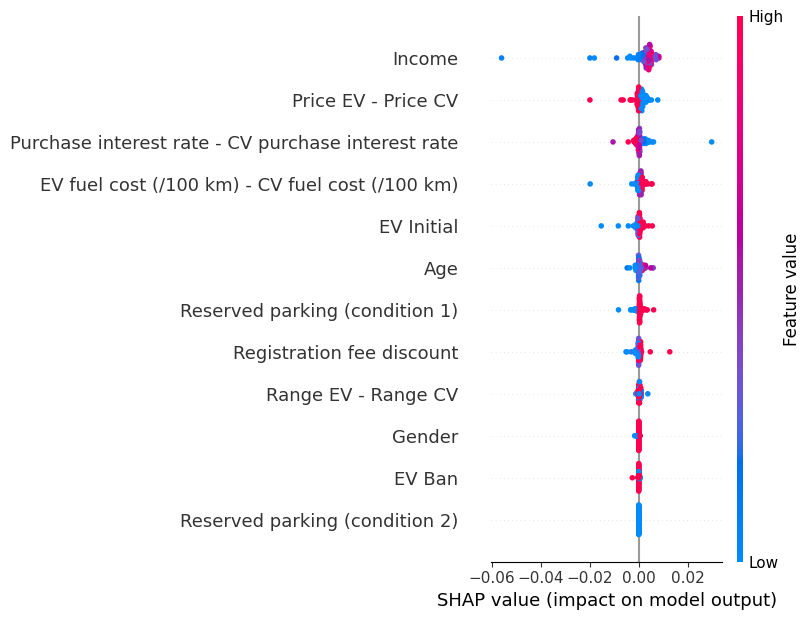

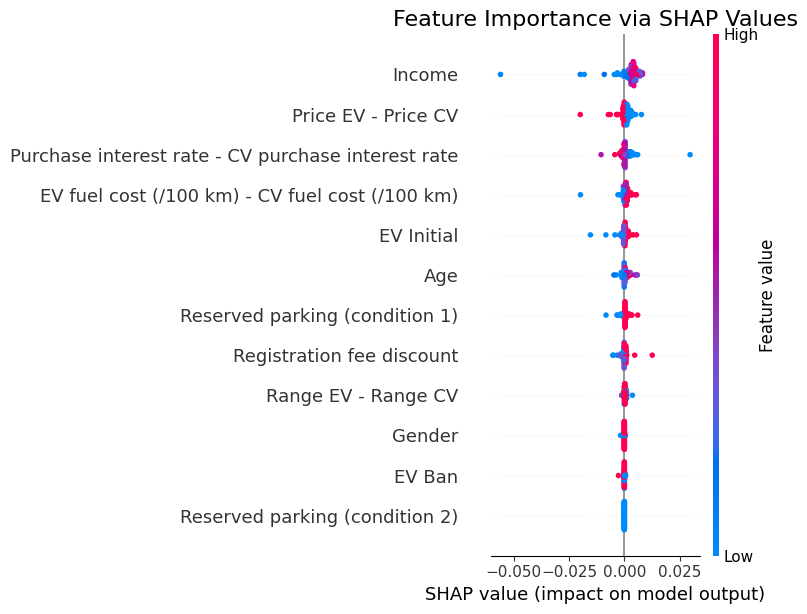

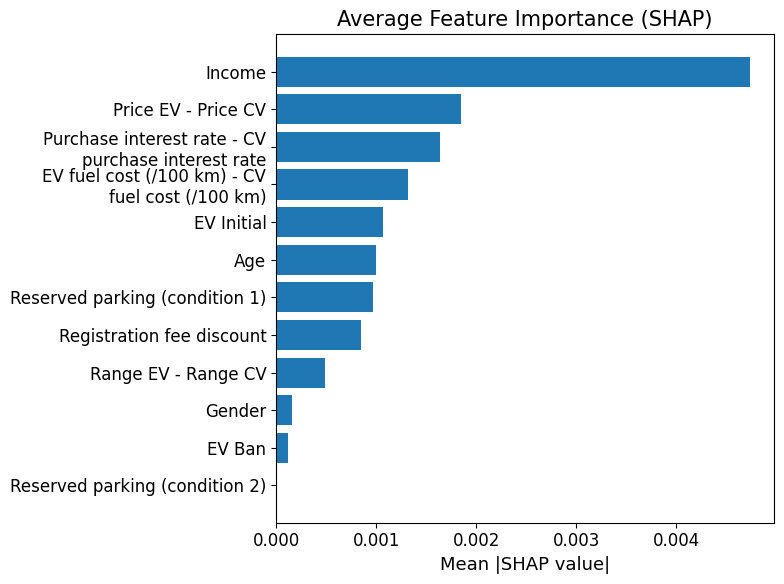

In [ ]:
# ============================================================
# 📊 SHAP Explainability for EV Adoption Neural Network (Fixed 3D Output)
# ============================================================

import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import textwrap
# --- Feature names (match model input order) ---
feature_names = [
    'ev_price_n', 'ev_fueln1', 'ev_rangen1', 'ev_loan', 'ev_reg1',
    'age', 'income', 'EV_Initial', 'EV_Ban', 'ev_res1', 'ev_res2', 'gender'
]

# --- Pretty names for plots ---
pretty_names = [
    'Price EV - Price CV',
    'EV fuel cost (/100 km) - CV fuel cost (/100 km)',
    'Range EV - Range CV',
    'Purchase interest rate - CV purchase interest rate',
    'Registration fee discount',
    'Age',
    'Income',
    'EV Initial',
    'EV Ban',
    'Reserved parking (condition 1)',
    'Reserved parking (condition 2)',
    'Gender'
]

assert len(feature_names) == X_valid.shape[1], "⚠️ Feature count mismatch!"

# --- SHAP explainer ---
try:
    print("🔍 Using DeepExplainer...")
    explainer = shap.DeepExplainer(best_model, X_train[:500])
    shap_values = explainer.shap_values(X_valid[:1000])

    if isinstance(shap_values, list):
        shap_values = shap_values[0]

    shap_values = np.array(shap_values)

    # ✅ FIX: squeeze (256, 12, 1) → (256, 12)
    if shap_values.ndim == 3 and shap_values.shape[-1] == 1:
        shap_values = shap_values.squeeze(-1)
        print(f"🔧 Squeezed SHAP values to shape: {shap_values.shape}")

except Exception as e:
    print(f"⚠️ DeepExplainer failed ({e}), switching to KernelExplainer (slower)...")
    background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
    explainer = shap.KernelExplainer(best_model.predict, background)
    shap_values = explainer.shap_values(X_valid[:500])
    shap_values = shap_values[0]

# --- Create DataFrame ---
shap_df = pd.DataFrame(shap_values, columns=feature_names)

print("\n📈 Mean absolute SHAP values (feature importance):")
print(shap_df.abs().mean().sort_values(ascending=False))

# --- SHAP Summary Plot ---
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values,
    X_valid[:len(shap_values)],
    feature_names=pretty_names,
    show=False
)
# --- Set font globally to Times New Roman ---
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 12

# --- SHAP Summary Plot ---
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values,
    X_valid[:len(shap_values)],
    feature_names=pretty_names,
    show=False
)
plt.title("Feature Importance via SHAP Values", fontsize=16, fontname='Times New Roman')
plt.tight_layout()
plt.show()

# --- SHAP Bar Plot (Mean |SHAP|) ---
mean_abs = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame({'Feature': pretty_names, 'Mean |SHAP|': mean_abs})
importance_df = importance_df.sort_values('Mean |SHAP|', ascending=True)

# Wrap long labels to 2 lines (≈30 characters per line)
importance_df['Feature_wrapped'] = [
    textwrap.fill(f, width=30, break_long_words=False) for f in importance_df['Feature']
]

plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature_wrapped'], importance_df['Mean |SHAP|'])
plt.xlabel("Mean |SHAP value|", fontname='Times New Roman', fontsize=13)
plt.ylabel("")
plt.title("Average Feature Importance (SHAP)", fontname='Times New Roman', fontsize=15)
plt.tight_layout()
plt.show()

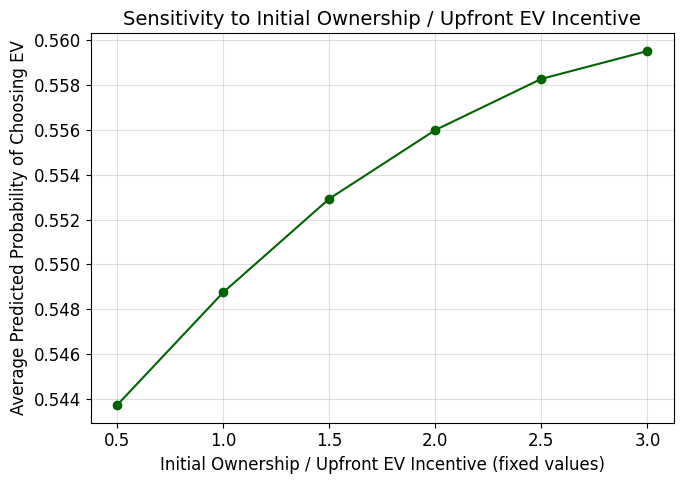


📊 Sensitivity to EV_Initial (Upfront EV Incentive):
   feature_value  Predicted_EV_Prob
0            0.5           0.543734
1            1.0           0.548756
2            1.5           0.552930
3            2.0           0.555993
4            2.5           0.558274
5            3.0           0.559514


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

# --- Plot font setup ---
rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# --- Feature name map (same as before) ---
feature_pretty = {
    'ev_price_n': 'Price EV - Price CV',
    'ev_fueln1': 'EV fuel cost (/100 km) - CV fuel cost (/100 km)',
    'ev_rangen1': 'Range EV - Range CV',
    'ev_loan': 'Purchase interest rate (EV - CV)',
    'ev_reg1': 'Registration fee discount',
    'ev_res1': 'Reserved parking (condition1)',
    'ev_res2': 'Reserved parking (condition2)',
    'gender': 'Gender',
    'income': 'Income',
    'age': 'Age',
    'EV_Initial': 'Initial Ownership / Upfront EV Incentive',
    'EV_Ban': 'Ban on CVs'
}

feature_names = ['ev_price_n', 'ev_fueln1', 'ev_rangen1',
                 'ev_loan', 'ev_reg1', 'age', 'income',
                 'EV_Initial', 'EV_Ban', 'ev_res1', 'ev_res2', 'gender']

# --- Sensitivity Function ---
def sensitivity_feature_change(model, X_base, feature_names, pretty_names,
                               var_name='EV_Initial', values=[0.5, 1.0, 1.5, 2.0, 3.0]):
    """
    Replaces all values of a selected feature (e.g., EV_Initial)
    with given constants and computes mean predicted EV probability.
    """
    idx = feature_names.index(var_name)
    results = []

    for val in values:
        X_temp = X_base.copy()
        X_temp[:, idx] = val   # replace column with a fixed value
        preds = model.predict(X_temp, verbose=0).mean()
        results.append({'feature_value': val, 'Predicted_EV_Prob': preds})

    df_results = pd.DataFrame(results)

    # --- Plot ---
    plt.figure(figsize=(7, 5))
    plt.plot(df_results['feature_value'], df_results['Predicted_EV_Prob'],
             marker='o', linestyle='-', color='darkgreen')
    plt.title(f"Sensitivity to {pretty_names[var_name]}", fontsize=14)
    plt.xlabel(f"{pretty_names[var_name]} (fixed values)")
    plt.ylabel("Average Predicted Probability of Choosing EV")
    plt.grid(True, alpha=0.4)
    plt.tight_layout()
    plt.show()

    return df_results

# --- Run analysis for EV_Initial ---
sensitivity_EVInitial = sensitivity_feature_change(
    model=best_model,
    X_base=X_valid,
    feature_names=feature_names,
    pretty_names=feature_pretty,
    var_name='EV_Initial',
    values=[0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
)

print("\n📊 Sensitivity to EV_Initial (Upfront EV Incentive):")
print(sensitivity_EVInitial)

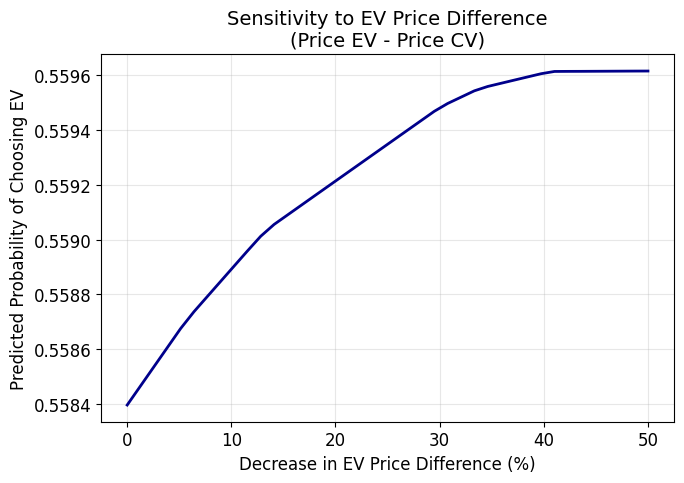


📊 Sensitivity results (sample):
   Price_Decrease_%  Predicted_EV_Prob
0          0.000000           0.558396
1          1.282051           0.558465
2          2.564103           0.558535
3          3.846154           0.558605
4          5.128205           0.558675
5          6.410256           0.558737
6          7.692308           0.558792
7          8.974359           0.558847
8         10.256410           0.558903
9         11.538462           0.558958


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

# --- Style ---
rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

feature_pretty = {
    'ev_price_n': 'Price EV - Price CV',
    'ev_fueln1': 'EV fuel cost (/100 km) - CV fuel cost (/100 km)',
    'ev_rangen1': 'Range EV - Range CV',
    'ev_loan': 'Purchase interest rate (EV - CV)',
    'ev_reg1': 'Registration fee discount',
    'ev_res1': 'Reserved parking (condition1)',
    'ev_res2': 'Reserved parking (condition2)',
    'gender': 'Gender',
    'income': 'Income',
    'age': 'Age',
    'EV_Initial': 'Initial Ownership',
    'EV_Ban': 'Ban on CVs'
}

feature_names = ['ev_price_n', 'ev_fueln1', 'ev_rangen1',
                 'ev_loan', 'ev_reg1', 'age', 'income',
                 'EV_Initial', 'EV_Ban', 'ev_res1', 'ev_res2', 'gender']

def sensitivity_ev_price(model, X_base, feature_names, pretty_names, var_name='ev_price_n',
                         num_points=30, scale_range=(1.0, 0.5)):
    idx = feature_names.index(var_name)
    scales = np.linspace(scale_range[0], scale_range[1], num_points)
    preds = []

    for s in scales:
        X_temp = X_base.copy()
        X_temp[:, idx] = X_base[:, idx] * s
        p = model.predict(X_temp, verbose=0).mean()
        preds.append(p)

    plt.figure(figsize=(7, 5))
    plt.plot((1 - scales) * 100, preds, lw=2, color='darkblue')
    plt.title(f"Sensitivity to EV Price Difference\n({pretty_names[var_name]})", fontsize=14)
    plt.xlabel("Decrease in EV Price Difference (%)")
    plt.ylabel("Predicted Probability of Choosing EV")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    sensitivity_df = pd.DataFrame({
        'Price_Decrease_%': (1 - scales) * 100,
        'Predicted_EV_Prob': preds
    })
    return sensitivity_df

# --- Run analysis ---
sensitivity_df = sensitivity_ev_price(
    model=best_model,
    X_base=X_valid,
    feature_names=feature_names,
    pretty_names=feature_pretty,
    var_name='ev_price_n',
    num_points=40,
    scale_range=(1.0, 0.5)
)

print("\n📊 Sensitivity results (sample):")
print(sensitivity_df.head(10))
